# 🧠🤖 Multilayer Perceptrons e Descida do Gradiente


Este notebook tem como objetivo introduzir o algoritmo de **descida do gradiente**, o método utilizado para treinamento de redes neurais modernas.

Nesta aula, você vai:
- Entender o que são problemas de otimização
- Conhecer diferentes tipos de problemas (lineares, inteiros, convexos, não convexos)
- Estudar em quais casos faz sentido usar algoritmos baseados em gradiente
- Aprender o algoritmo de descida do gradiente
- Visualizar a aplicação do algoritmo em funções simples
- Explorar o impacto da taxa de aprendizado (learning rate)
- Resolver um problema simples usando descida de gradiente

## Multi-Layer Perceptrons (MLP)

### Definição

Estudamos até agora as redes neurais do tipo Perceptron e seu algoritmo de aprendizado. Vimos que o Perceptron é um classificador linear, isto é, sua fronteira de decisão é um hiperplano. Um corolário deste fato é que o Perceptron é adequado para tarefas de classificação nas quais os dados de diferentes classes são linearmente separáveis.

A primeira arquitetura que vamos estudar que supera esta limitação são as redes do tipo **Perceptron de Múltiplas Camadas** ou **Multilayer Perceptron (MLP)**. 

Como ilustrado na figura abaixo, estas redes neurais são construídas organizando grupos de neurônios em camadas que são densamente conectadas às saída da camada anterior. 

As camadas são de diferentes tipos:

- A primeira camada é chamada de **camada de entrada** e recebe os dados de entrada do modelo (e.g., pixels de uma imagem), 
- A última camada é chamada de **camada de saída** e produz o valor de interesse (e.g., probabilidade por classe, valor de regressão, etc.). 
- As camadas intermediárias são chamadas de **camadas ocultas** e os valores delas, em geral, não são facilmente interpretáveis como no caso da entrada e da saída. Contudo, veremos mais para frente no curso que dependendo da metodologia de treinamento da rede, as camadas intermediárias podem apresentar propriedades interessantes e podem ser utilizadas para abordar algumas tarefas.

As camadas de uma rede MLP também podem ser chamadas de camadas:
- densas (*dense*) ou
- totalmente conectadas (*fully connected*)

As redes MLP são exemplos de camadas do tipo ***feedforward*** (com "alimentação para frente") uma vez que os dados navegam da entrada em direção à saída.

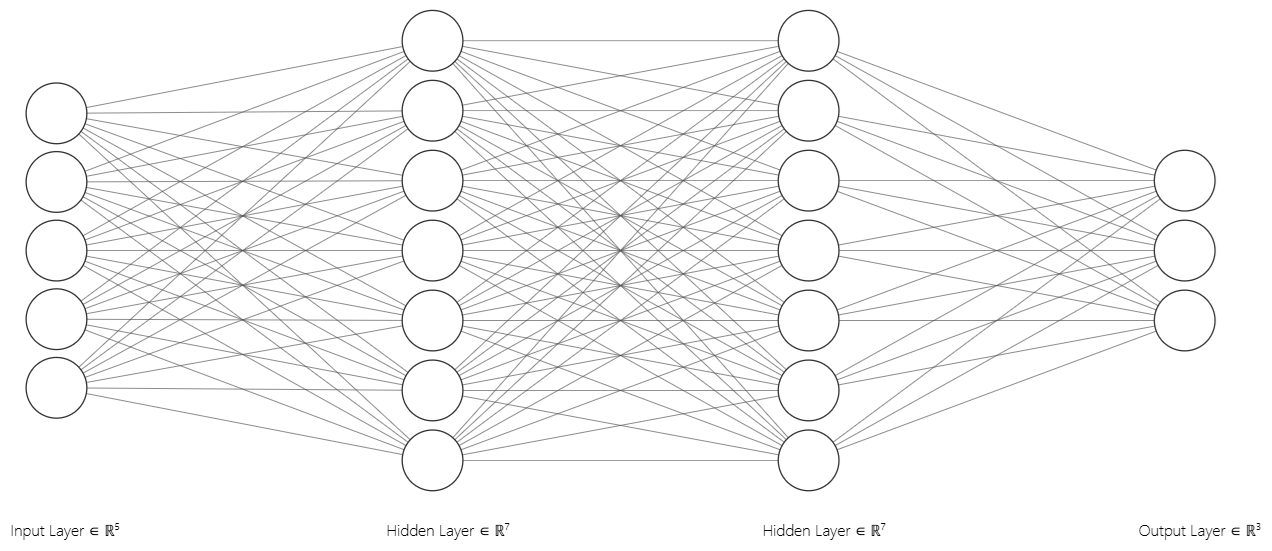

Matematicamente, cada camada $f_i$ de uma rede MLP implementa a função: 

$$
f_i(a) = \sigma_i \left( \mathbf{W_i} a + b_i \right)
$$

onde $\mathbf{W_i}$, $b_i$ e $\sigma_i$ são a matriz de pesos, o vetor de biases e a função de ativação da camada $i$.

Portanto, dada uma entrada $x$, a saída da rede $o$ será a composição das funções implementadas pelas camadas: 

$$
o = f_n(\cdots f_2(f_1(x)))
$$

ou, usando a notação de composição de funções: 

$$
o = (f_n \circ ... \circ f_2 \circ f_1)(x)
$$


### Implementação

Vamos primeiro implementar uma classe representando uma camada totalmente conectada:

In [1]:

from collections.abc import Callable
import numpy as np

class FullyConnectedLayer:
    def __init__(self,
                 initial_weights: np.ndarray,
                 initial_bias: np.ndarray,
                 activation_fn: Callable):

        assert len(initial_weights.shape) == 2, "weights matrix should be n_classes x input_dim"
        assert len(initial_bias.shape) == 1 or (len(initial_bias.shape) == 2 and initial_bias.shape[1] == 1), "bias should be a vector with size equals to the number of classes."

        self._weights = initial_weights
        self._bias = initial_bias
        self._activation_fn = activation_fn

    def forward(self, x: np.ndarray):
        z = np.matmul(self._weights, x) + self._bias
        o = self._activation_fn(z)
        return o



A classe abaixo representa a rede MLP. 
- O construtor recebe uma lista de camadas totalmente conectadas como entrada e verifica se as matrizes são consistentes entre si.
- O método forward usa a saída de cada camada como entrada para a próxima e retorna o valor da última camada.

In [2]:

from collections.abc import Callable
import numpy as np

class MultilayerPerceptron:
    def __init__(self,
                 layers: list[FullyConnectedLayer]):
        self._layers = layers
        self._check_layers_consistency()

    def forward(self, x: np.ndarray) -> np.ndarray:
        o = x
        for l in self._layers:
            o = l.forward(o)
        return o

    def train(self, X: np.ndarray, y: np.ndarray):
        """Não estudamos isto ainda..."""
        raise NotImplementedError()

    def _check_layers_consistency(self):
        for i in range(len(self._layers) - 1):
            layer = self._layers[i]
            next_layer = self._layers[i + 1]

            # check if weight matrix and bias are consistent
            assert layer._weights.shape[0] == layer._bias.shape[0], f'weight matrix and bias have inconsistent size in layer {i}'

            # check if weight matrices from consecutive layers match
            assert next_layer._weights.shape[1] == layer._weights.shape[0], f'number of columns from layer {i+1} is different from output size of layer {i}'


In [3]:

def sigmoid(x):
    """
    Função sigmoid: sigma(x) = 1 / (1 + exp(-x))
    Pode ser usada com escalares, vetores ou matrizes NumPy.
    """
    return 1 / (1 + np.exp(-x))


mlp = MultilayerPerceptron([
    FullyConnectedLayer(np.random.random((4, 2)), np.random.random((4, 1)), sigmoid),  # hidden layer 1 com 5 neuronios
    FullyConnectedLayer(np.random.random((5, 4)), np.random.random((5, 1)), sigmoid),  # hidden layer 2 com 7 neuronios
    FullyConnectedLayer(np.random.random((3, 5)), np.random.random((3, 1)), sigmoid),  # output layer com 3 neuronios
])

x = np.random.random((2, 1))

mlp.forward(x)

array([[0.84733421],
       [0.82398304],
       [0.95555496]])

### Aproximação Universal de Funções


MLPs e outras redes neurais multicamadas possuem uma propriedade muito importante descrita no teorema abaixo [1, 2, 3].

🚀 **Teorema da Aproximação Universal:** Redes neurais com sequências de 2 ou mais camadas não lineares são **aproximadores universais de funções**, isto é, elas são capazes de aproximar qualquer função não-linear contínua, dado um número suficientemente grande de neurônios. Posteriormente, foi provado que com sequências de 3 ou mais camadas não lineares é possível aproximar inclusive funções descontínuas! 

💫 **Importante**: Notem que o teorema não vale apenas para redes MLP, mas para qualquer tipo de arquitetura com duas ou mais camadas em sequência. 


**Referências**

[1] Cybenko, G. (1989). "Approximation by superpositions of a sigmoidal function"

[2] Hornik, K., Stinchcombe, M., & White, H. (1989). Multilayer feedforward networks are universal approximators. Neural networks, 2(5), 359-366.

[3] Hornik, K. (1991). Approximation capabilities of multilayer feedforward networks. Neural networks, 4(2), 251-257.

### Como Treinar? 

Acabamos de receber ótimas notícias: sabemos como implementar um modelo geral que é capaz de aproximar quaisquer funções, incluindo quaisquer fronteiras de decisão! 

Mas surge um novo problema: como treinar estes modelos? 

Em 1985, Rumelhart, Hinton e Williams [4] apresentaram o algoritmo **backpropagation** que pode ser utilizado para treinar redes MLP. Este algoritmo é basedo no algoritmo de **descida do gradiente** (*gradient descent*). Antes de estudarmos o algoritmo **backpropagation**, vamos compreender o que são problemas de otimização e o algoritmo de **descida do gradiente** como um algoritmo para solucionar uma classe de problemas de otimização.

**Referências**

[4] Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning representations by back-propagating errors. nature, 323(6088), 533-536.


## O Algoritmo de Descida do Gradiente

### Problemas de Otimização


Problemas de otimização são aqueles que podem ser escritos na forma: 

$$
x^* = \arg\min_{x \in S} f(x) \text{, sujeito às restrições R}
$$

ou

$$
x^* = \arg\max_{x \in S} f(x) \text{, sujeito às restrições R}
$$

onde:

- $f(x)$ é a **função objetivo** a ser minimizada ou maximizada.
- $S$ é o **domínio** das soluções, isto é, os conjuntos de valores válidos como soluções.
- $x$ é uma solução possível.
- $x^*$ é a solução ótima.
- $R$ é uma coleção de restrições que precisam ser obedecidas. A coleção pode ser vazia.


### O Algoritmo de Descida do Gradiente (Gradient Descent)

O gradiente é o vetor de derivadas parciais de uma função multivariada $f$:

$$
\nabla f(x_0, \cdots, x_n) = \left( \frac{\partial f}{\partial x_0}, \cdots, \frac{\partial f}{\partial x_n}  \right)
$$

Como ilustrado nas figuras a seguir, o gradiente sempre aponta para a direção de crescimento da função. 


<table>
<tr>
<td>
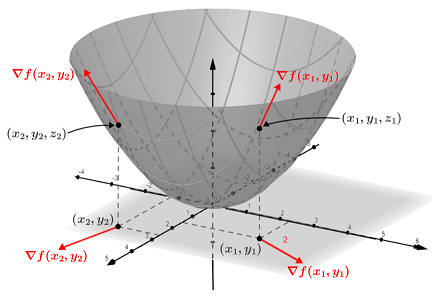
</td>
<td>
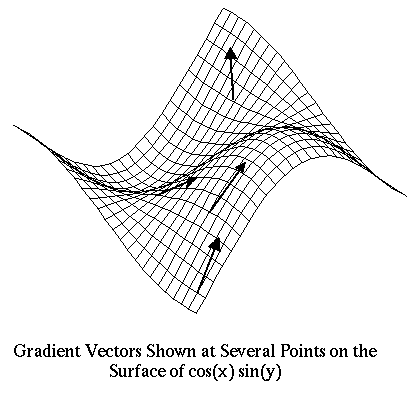
</td>
</tr>
</table>


Dada uma função objetivo diferenciável, o **algoritmo de descida do gradiente** (*gradient descent*) se propõe a, partindo de um **ponto inicial aleatório**, caminhar na direção **contrária à do vetor gradiente**, isto é, na direção de decrescimento da função. O tamanho dos passos é controlado por um **hiperparâmetro** chamado de **taxa de aprendizado**. 

**Regra de atualização**:

$$
w_{t+1} = w_t - \alpha \nabla f(w)
$$

onde:
- $w$ é a variável de otimização
- $\alpha$ é a taxa de aprendizado (*learning rate*)
- $\nabla f(w)$ é o vetor gradiente da função $f$ no ponto $w$.

Dado um número suficiente grande de passos e uma taxa de aprendizado suficientemente pequena, é possível provar que **o algoritmo de descida do gradiente sempre converge para um mínimo local**.


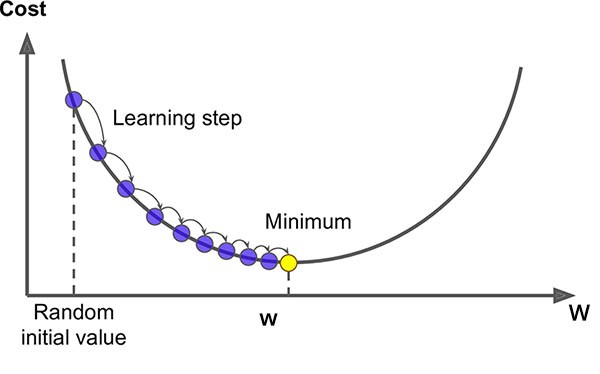

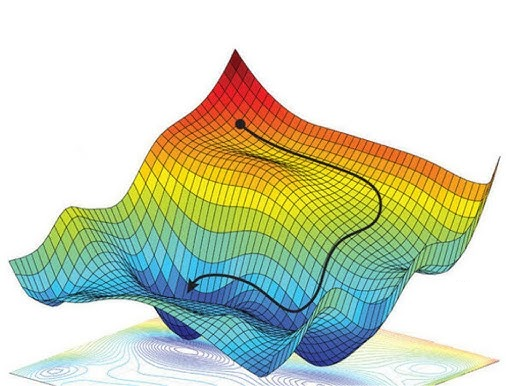

### Implementação

In [4]:
def gradient_descent(gradient_fn, initial_val, learning_rate, n_iter):
    w = initial_val

    for _ in range(n_iter):
        w = w - learning_rate * gradient_fn(w)

    return w


### Máximos Globais vs. Locais


Como indicado na Figura abaixo, funções podem possuir mínimos e máximos globais e locais. 

Nem todo algoritmo de otimização é capaz de encontrar ótimos globais. O algoritmo de descida do gradiente, por exemplo, só possui garantias de convergência para ótimos locais. Felizmente, em muitos problemas de interesse, ótimos locais representam soluções boas o suficiente.


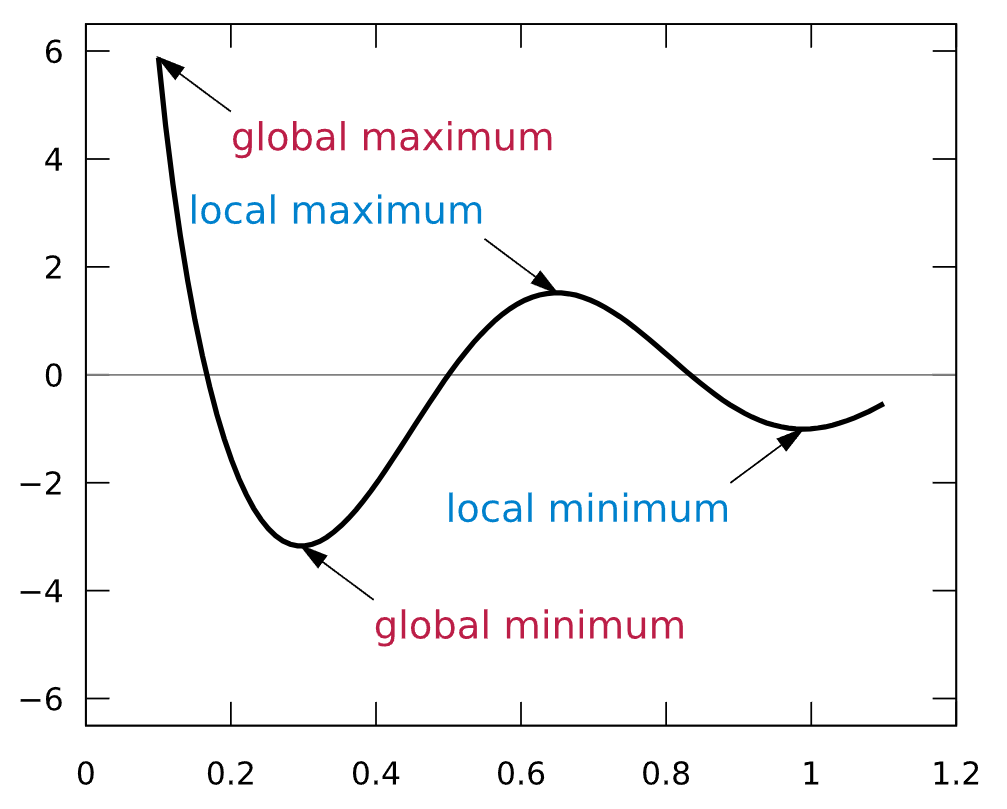

### Relembrando algumas Regras de Diferenciação


#### Derivada da Soma

A derivada da soma de duas funções é igual à soma das derivadas dessas funções.

Se $ f(x) $ e $ g(x) $ são diferenciáveis, então:

$$
\frac{d}{dx}[f(x) + g(x)] = \frac{d}{dx} f(x) + \frac{d}{dx} g(x)
$$


#### Derivada de Constantes Aditivas e Multiplicativas

A derivada de constantes aditivas é zero: 

$$
\frac{d}{dx}[c + f(x)] = \frac{d}{dx} c + \frac{d}{dx} f(x) = \frac{d}{dx}f(x)
$$

Já a derivada de uma constante multiplicada por uma função é a constante vezes a derivada da função. 

$$
\frac{d}{dx}[c\ f(x)] = c\ \frac{d}{dx}[f(x)]
$$

Por exemplo: 

$$
\frac{d}{dx}[3 * f(x) + 5] = 3 \frac{d}{dx} f(x)
$$

#### Derivada de Potências

Para uma função do tipo $ f(x) = x^n $, a derivada é dada multiplicando o expoente pela base elevada a um grau menor.

$$
\frac{d}{dx}[x^n] = n x^{n-1}
\quad \text{(para todo número real } n)
$$

Por exemplo:

$$
\frac{d}{dx}[x^5] = 5x^4
$$



#### Derivada de $ f(x) = e^x $

A função exponencial natural $ e^x $ tem a propriedade especial de ser igual à sua própria derivada.

$$
\frac{d}{dx}[e^x] = e^x
$$

Por exemplo:

$$
\frac{d}{dx}[3e^x] = 3e^x
$$



#### Derivada de $ f(x) = \log(x) $

A derivada de $\log_b(x)$ para $ x > 0 $ é dada por: 

$$
\frac{d}{dx}\log_b(x) = \frac{1}{x \ln(b)}
$$

A função $\log$ é indefinida para $x \leq 0$. 

Um corolário da regra acima é que a derivada do logaritmo natural de $ x $ é o inverso de $ x $:

$$
\frac{d}{dx}\ln(x) = \frac{1}{x}
$$

**Nota**: É comum que o logaritmo natural seja representado apenas por $\log(x)$.



#### Derivadas de Funções Trigonométricas

As funções trigonométricas básicas têm derivadas conhecidas:

$$
\frac{d}{dx} \sin(x) = \cos(x) 
$$

$$
\frac{d}{dx} \cos(x) = -\sin(x) 
$$

$$
\frac{d}{dx} \tan(x) = \sec^2(x)
$$

Por exemplo:

$$
\frac{d}{dx} \sin(x) + \cos(x) = \cos(x) - \sin(x)
$$


#### Derivada do Produto

Para o produto de duas funções, a derivada é feita derivando a primeira e multiplicando pela segunda, somado à primeira multiplicada pela derivada da segunda.

$$
\frac{d}{dx} f(x) \cdot g(x) = g(x) \frac{d}{dx}[f(x)] + f(x) \frac{d}{dx}[g(x)]
$$

Por exemplo, se $ f(x) = x^2 $ e $ g(x) = \sin(x) $:

$$
\frac{d}{dx}[x^2 \cdot \sin(x)] = 2x \cdot \sin(x) + x^2 \cdot \cos(x)
$$


#### Regra da Cadeia

Quando uma função está composta dentro de outra, derivamos a externa e multiplicamos pela derivada da interna.

Se $ y = f(g(x)) = (f \circ g)(x) $, então:

$$
\frac{d}{dx} f(g(x)) = f'(g(x)) \cdot g'(x)
$$

Por exemplo, se $ f(x) = \sin(x^2) $:

$$
\frac{d}{dx}[\sin(x^2)] = \cos(x^2) \cdot 2x
$$



#### Derivadas Parciais e o Vetor Gradiente

Quando lidamos com funções de várias variáveis, a derivada parcial mede a variação da função em relação a uma variável, mantendo as outras constantes. 

Por exemplo, se $f(x, y) = xy + y + x$: 

$$
\frac{\partial f}{\partial x} = y + 1
$$

$$
\frac{\partial f}{\partial y} = x + 1
$$

O vetor gradiente "agrupa" todas as derivadas parciais. Portanto, para $ f(x, y) $, temos:

$$
\nabla f = \left( \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} \right)
$$

Por exemplo, se $ f(x, y) = x^2y + y^3 $, então:

$$
\frac{\partial f}{\partial x} = 2xy, \quad \frac{\partial f}{\partial y} = x^2 + 3y^2
$$

$$
\nabla f = (2xy, x^2 + 3y^2)
$$


### Em que problemas de otimização podemos utilizar algoritmos baseados em gradiente?

Algoritmos baseados em gradiente são adequados quando:
- A função objetivo é **diferenciável** 
- Estamos lidando com **variáveis contínuas**
- Podemos calcular ou estimar o gradiente da função

**Eles não são adequados para:**
- Funções com variáveis inteiras
- Funções com muitas descontinuidades

## Exemplos 

Nos exemplos abaixo, vamos usar uma variação do algoritmo em que o histórico de variáveis é armazenado. 

⚠️ **Cuidado**: Salvar o valor das variáveis pode consumir muita memória se o número de variáveis é grande!

In [1]:

def gradient_descent(gradient_fn, initial_val, learning_rate, n_iter):
    w = initial_val
    history = [w]

    for _ in range(n_iter):
        w = w - learning_rate * gradient_fn(w)
        history.append(w)

    return history

### Exemplo: Função $x^2$

In [6]:
import numpy as np

def objective_fn(x):
    return x ** 2

def gradient_fn(x):
    return 2 * x

history = gradient_descent(gradient_fn, initial_val=-5.0, learning_rate=0.1, n_iter=20)
history[-1]

-0.057646075230342354

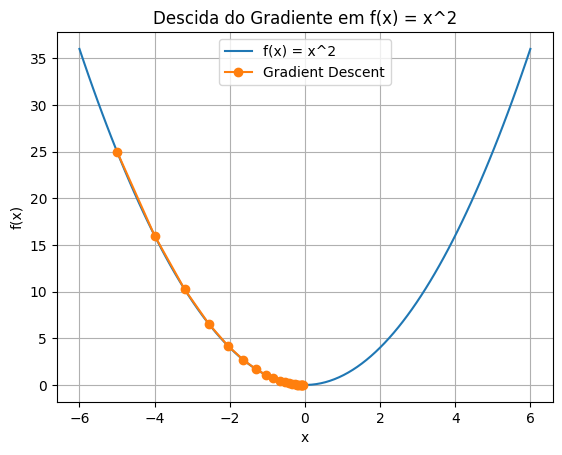

In [7]:
import numpy as np
import matplotlib.pyplot as plt

x_vals = np.linspace(-6, 6, 100)
plt.plot(x_vals, objective_fn(x_vals), label='f(x) = x^2')
plt.plot(history, [objective_fn(x) for x in history], 'o-', label='Gradient Descent')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Descida do Gradiente em f(x) = x^2')
plt.legend()
plt.grid(True)
plt.show()

### Exemplo: $4x^4 - 2x^3 - 12 x^2$

In [15]:
import numpy as np

def objective_fn(x):
    return 4 * x ** 4 - 2 * x ** 3 - 12 * x ** 2

def gradient_fn(x):
    return 16 * x ** 3 - 6 * x ** 2 - 24 * x

history = gradient_descent(gradient_fn, initial_val=0.2, learning_rate=0.01, n_iter=20)
history[-1]

1.42645368561815

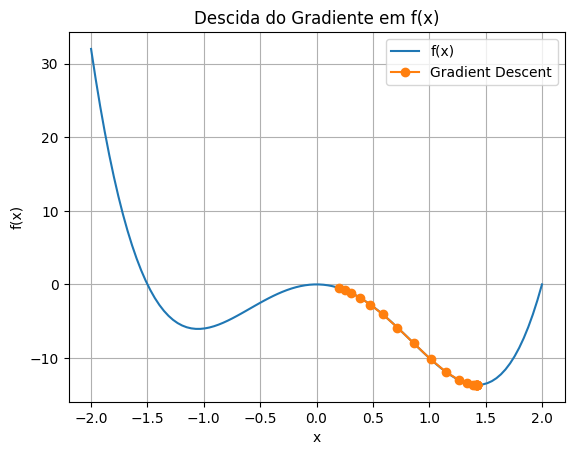

In [16]:
x_vals = np.linspace(-2, 2, 100)
plt.plot(x_vals, objective_fn(x_vals), label='f(x)')
plt.plot(history, [objective_fn(x) for x in history], 'o-', label='Gradient Descent')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Descida do Gradiente em f(x)')
plt.legend()
plt.grid(True)
plt.show()

### Exemplo: $x^3$

In [102]:
import numpy as np

def objective_fn(x):
    return x ** 3

def gradient_fn(x):
    return 2 * x ** 2

history = gradient_descent(gradient_fn, initial_val=1.7, learning_rate=0.1, n_iter=20)
history[-1]

0.19756905549811962

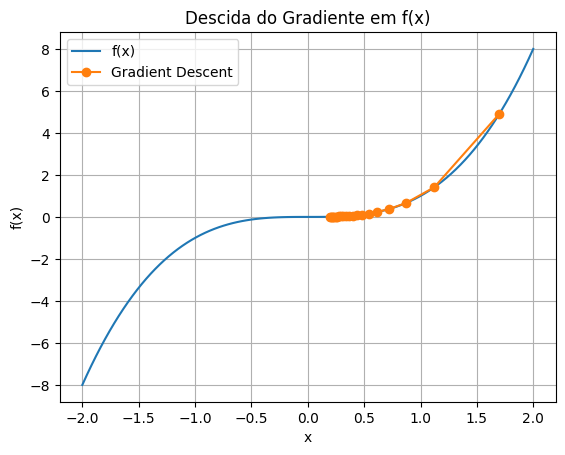

In [103]:
x_vals = np.linspace(-2, 2, 100)
plt.plot(x_vals, objective_fn(x_vals), label='f(x)')
plt.plot(history, [objective_fn(x) for x in history], 'o-', label='Gradient Descent')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Descida do Gradiente em f(x)')
plt.legend()
plt.grid(True)
plt.show()

### Exemplo: $x^2 + y^2$

In [104]:
import numpy as np
import plotly.graph_objects as go

def objective_fn(w):
    x, y = w
    return x**2 + y**2

def gradient_fn(w):
    x, y = w
    return np.array([2*x, 2*y])

# Run gradient descent
initial_w = np.array([2.0, 2.0])
learning_rate = 0.1
n_iter = 30
history = gradient_descent(gradient_fn, initial_w, learning_rate, n_iter)
history[-1]

array([0.00247588, 0.00247588])

In [105]:

# Extract x, y, and z = f(x, y) from history
x_path = [w[0] for w in history]
y_path = [w[1] for w in history]
z_path = [objective_fn(w) for w in history]

# Surface for f(x, y)
X = np.linspace(-3, 3, 100)
Y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(X, Y)
Z = X**2 + Y**2

# Create the 3D plot
fig = go.Figure()

# Function surface
fig.add_trace(go.Surface(
    z=Z, x=X, y=Y,
    colorscale='Viridis',
    opacity=0.5,
    showscale=False,
    name='Surface'))

# Descent path
fig.add_trace(go.Scatter3d(
    x=x_path,
    y=y_path,
    z=z_path,
    mode='lines+markers',
    line=dict(color='red', width=4),
    marker=dict(size=4, color='red'),
    name='Gradient Descent Path'
))

# Layout
fig.update_layout(
    title='Gradient Descent Path on f(x, y) = x² + y²',
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='f(x, y)',
        aspectmode='manual',  # Set fixed aspect ratio
        aspectratio=dict(x=1.5, y=1.5, z=0.7)  # Tweak this for better visuals
    ),
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=0, r=0, b=100, t=50)
)

fig.show()

### Exemplo: $x^2 y$

In [106]:
import numpy as np
import plotly.graph_objects as go

def objective_fn(w):
    x, y = w
    return x**2 * y

# Gradient of the function
def gradient_fn(w):
    x, y = w
    return np.array([2*x*y, x**2])


# Run gradient descent
initial_w = np.array([2.5, 2.5])
learning_rate = 0.25
n_iter = 30
history = gradient_descent(gradient_fn, initial_w, learning_rate, n_iter)
history[-1]

array([-2.02807937e-07,  7.97905982e-01])

In [107]:

# Extract x, y, and z = f(x, y) from history
x_path = [w[0] for w in history]
y_path = [w[1] for w in history]
z_path = [objective_fn(w) for w in history]

# Surface for f(x, y)
X = np.linspace(-3, 3, 100)
Y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(X, Y)
Z = X**2 * Y

# Create the 3D plot
fig = go.Figure()

# Function surface
fig.add_trace(go.Surface(
    z=Z, x=X, y=Y,
    colorscale='Viridis',
    opacity=0.5,
    showscale=False,
    name='Surface'))

# Descent path
fig.add_trace(go.Scatter3d(
    x=x_path,
    y=y_path,
    z=z_path,
    mode='lines+markers',
    line=dict(color='red', width=4),
    marker=dict(size=4, color='red'),
    name='Gradient Descent Path'
))

# Layout
fig.update_layout(
    title='Gradient Descent Path on f(x, y) = x² + y²',
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='f(x, y)',
        aspectmode='manual',  # Set fixed aspect ratio
        aspectratio=dict(x=1.5, y=1.5, z=0.7)  # Tweak this for better visuals
    ),
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=0, r=0, b=100, t=50)
)

fig.show()

## Atividades

Implemente as funções de gradiente e analise o efeito de mudar a learning rate na convergência do gradient descent.


### Preparação

In [108]:
import numpy as np
import matplotlib.pyplot as plt

def plot_history_2d(low, high, fn, history):
    x_vals = np.linspace(low, high, 100)
    plt.plot(x_vals, fn(x_vals), label='f(x)')
    plt.plot(history, [fn(x) for x in history], 'o-', label='Gradient Descent')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('Descida do Gradiente em f(x)')
    plt.legend()
    plt.grid(True)
    plt.show()


### Atividade: $sin(x)$

In [ ]:
import numpy as np

def objective_fn(x):
    return np.sin(x)

def gradient_fn(x):
    return ... # <<< TODO


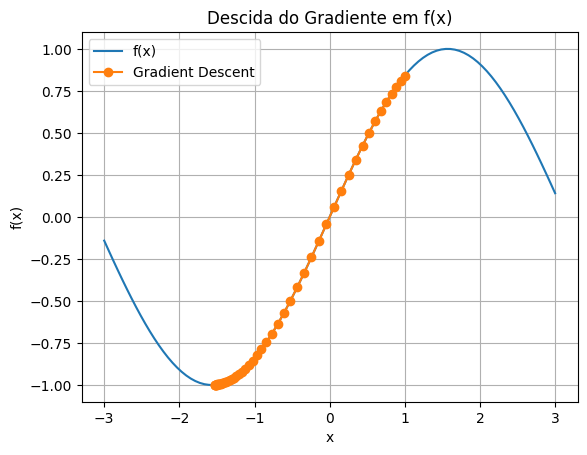

In [110]:
history = gradient_descent(
    gradient_fn,
    initial_val=1,
    learning_rate=0.1,
    n_iter=50)

plot_history_2d(-3, 3, objective_fn, history)

### Atividade: $x\ sin(x)$

In [ ]:
import numpy as np

def objective_fn(x):
    return x * np.sin(x)

def gradient_fn(x):
    return ...  # <<< TODO


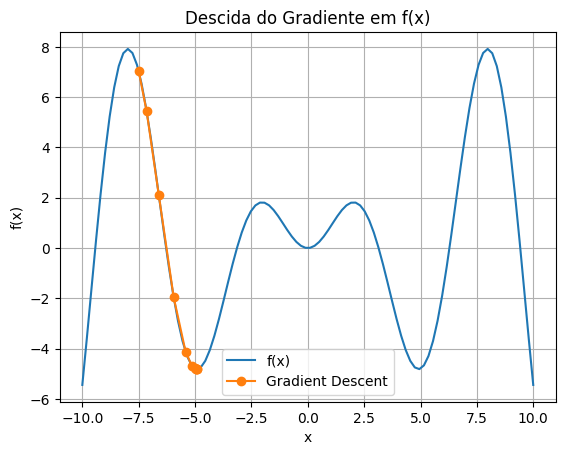

In [112]:
history = gradient_descent(
    gradient_fn,
    initial_val=-7.5,
    learning_rate=0.1,
    n_iter=10)

plot_history_2d(-10, 10, objective_fn, history)

### Atividade: $-3x^3 - 5x^2 + 3x - 5$

In [ ]:
import numpy as np

def objective_fn(x):
    return -3 * x ** 3 - 5 * x ** 2 + 3 * x - 5

def gradient_fn(x):
    return ...  # <<< TODO


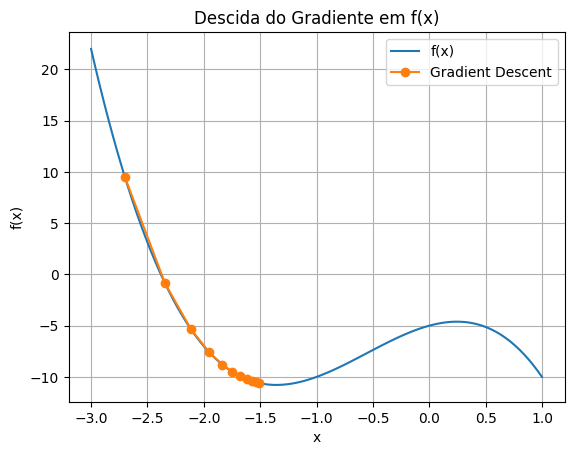

In [114]:
history = gradient_descent(
    gradient_fn,
    initial_val=-2.7,
    learning_rate=0.01,
    n_iter=10)

plot_history_2d(-3, 1, objective_fn, history)

### Atividade: $x^2 + x^2\ cos(x)^2 $

In [ ]:
import numpy as np

def objective_fn(x):
    return x ** 2 + (x ** 2) * (np.cos(x) ** 2)

def gradient_fn(x):
    return ...  # <<< TODO


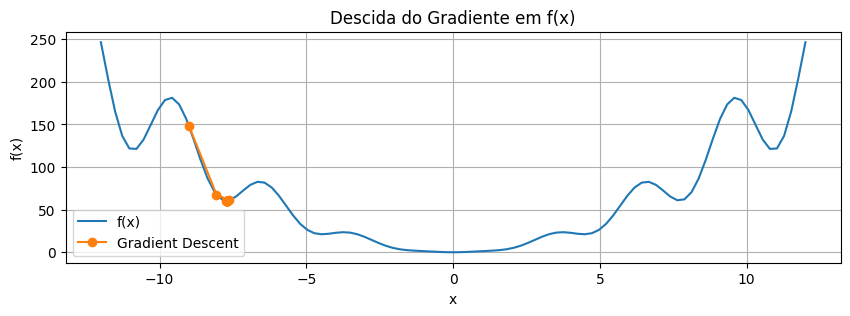

In [116]:
history = gradient_descent(
    gradient_fn,
    initial_val=-9,
    learning_rate=1e-2,
    n_iter=20)

plt.figure(figsize=(10, 3))
plot_history_2d(-12, 12, objective_fn, history)

### Atividade: $x^2 + y^2 + \left( x^2 + y^2 \right) * \left[cos(x)^2 + cos(y)^2 \right]$

In [ ]:
import numpy as np

def objective_fn(w):
    x, y = w
    return (x ** 2 + y ** 2) + (x ** 2 + y ** 2) * (np.cos(x) ** 2 + np.cos(y) ** 2)

def gradient_fn(w):
    x, y = w
    return ...  # <<< TODO


In [120]:
history = gradient_descent(
    gradient_fn,
    initial_val=np.array([-15, -15]),
    learning_rate=0.005,
    n_iter=20)

history[-1]

array([-10.47556881, -10.47556881])

In [121]:

# Extract x, y, and z = f(x, y) from history
x_path = [w[0] for w in history]
y_path = [w[1] for w in history]
z_path = [objective_fn(w) for w in history]

# Surface for f(x, y)
X = np.linspace(-20, 20, 100)
Y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(X, Y)
Z = X ** 2 + Y ** 2 + (X ** 2 + Y ** 2) * (np.cos(X) ** 2 + np.cos(Y) ** 2)

# Create the 3D plot
fig = go.Figure()

# Function surface
fig.add_trace(go.Surface(
    z=Z, x=X, y=Y,
    colorscale='Viridis',
    opacity=0.5,
    showscale=False,
    name='Surface'))

# Descent path
fig.add_trace(go.Scatter3d(
    x=x_path,
    y=y_path,
    z=z_path,
    mode='lines+markers',
    line=dict(color='red', width=4),
    marker=dict(size=4, color='red'),
    name='Gradient Descent Path'
))

# Layout
fig.update_layout(
    title='Gradient Descent Path on f(x, y)',
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='f(x, y)',
        aspectmode='manual',  # Set fixed aspect ratio
        aspectratio=dict(x=1.5, y=1.5, z=0.7)  # Tweak this for better visuals
    ),
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=0, r=0, b=100, t=50)
)

fig.show()